# **Time Series Project: Forecasting Amazon Stock Prices**

----------------
## **Context:** 
---------------- 
In the last few decades, there's been an **explosive increase in the average person's interest in the stock market.** This makes stock value prediction an interesting and popular problem to explore.

This dataset consists of monthly average stock closing prices of Amazon over a period of 12 years from 2006 to 2017. My goal is to **build a time series model** using the AR, MA, ARMA, and ARIMA models in order to **forecast the stock closing price of Amazon.**

--------------------------
## **Data Dictionary:**
--------------------------
- **date:** Date when the price was collected
- **close:** Closing price of the stock

## **Importing the necessary libraries and overview of the dataset**

In [1]:
!pip install statsmodels==0.12.1

In [2]:
# Version check 

import statsmodels

statsmodels.__version__

'0.12.1'

In [3]:
# Importing libraries for data manipulation
import pandas as pd

import numpy as np

# Importing libraries for visualization
import matplotlib.pylab as plt

import seaborn as sns

# Importing library for date manipulation
from datetime import datetime

# To calculate the MSE or RMSE
from sklearn.metrics import mean_squared_error

# Importing acf and pacf functions
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Importing models from statsmodels library
from statsmodels.tsa.ar_model import AutoReg

from statsmodels.tsa.arima.model import ARIMA

# To ignore the warnings
import warnings
warnings.filterwarnings('ignore')

### **Loading the dataset**

In [4]:
# If you are having an issue while loading the excel file in pandas, please run the below command in anaconda prompt, otherwise ignore.
# conda install -c anaconda xlrd

In [5]:
df = pd.read_excel('amazon_stocks_prices.xlsx')

df.head()

,date,close
0,2006-01-01,45.22
1,2006-02-01,38.82
2,2006-03-01,36.38
3,2006-04-01,36.32
4,2006-05-01,34.13


### **Checking info of the dataset** 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    144 non-null    datetime64[ns]
 1   close   144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB


Observations:
- There are 144 entries in the dataset and 2 columns.
- date column is the first and has a data type of datetime64[ns]
- close is the next time and data type is float.
- There are no missing values in the data set.

In [7]:
# Setting date as the index

df = df.set_index(['date'])

df.head()

,close
date,
2006-01-01,45.22
2006-02-01,38.82
2006-03-01,36.38
2006-04-01,36.32
2006-05-01,34.13


Now, let's **visualize the time series** to get an idea about the trend and/or seasonality within the data.

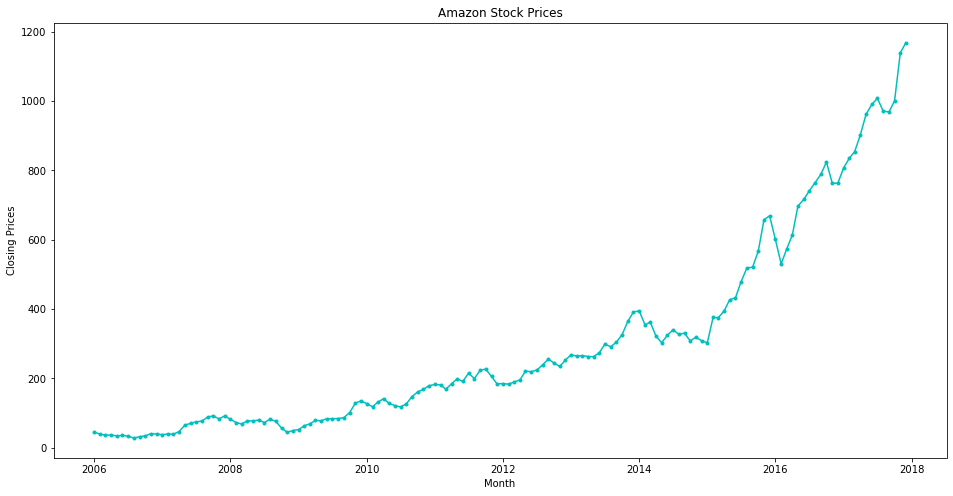

In [8]:
# Visualizing the time series

plt.figure(figsize = (16, 8))

plt.xlabel("Month")

plt.ylabel("Closing Prices")

plt.title('Amazon Stock Prices')

plt.plot(df.index, df.close, color = 'c', marker = '.')

**Observations:**
- We can see that the series has an **upward trend with some seasonality.** This implies that the **average stock price of Amazon has been increasing almost every year.**
- Before building different models, it is important to **check whether the series is stationary or not.**

Let us first split the dataset into train and test sets.

## **Splitting the dataset**

In [9]:
# Splitting the data into train and test sets

df_train = df.loc['2006-01-01' : '2015-12-01']

df_test = df.loc['2016-01-01' : '2017-12-01']

print(df_train)

print(df_test)

             close
date              
2006-01-01   45.22
2006-02-01   38.82
2006-03-01   36.38
2006-04-01   36.32
2006-05-01   34.13
...            ...
2015-08-01  518.46
2015-09-01  520.96
2015-10-01  566.74
2015-11-01  657.70
2015-12-01  669.26

[120 rows x 1 columns]
              close
date               
2016-01-01   601.06
2016-02-01   530.62
2016-03-01   572.37
2016-04-01   613.59
2016-05-01   697.47
2016-06-01   716.39
2016-07-01   741.47
2016-08-01   764.84
2016-09-01   788.97
2016-10-01   824.44
2016-11-01   763.34
2016-12-01   763.33
2017-01-01   807.51
2017-02-01   835.75
2017-03-01   854.24
2017-04-01   903.39
2017-05-01   961.72
2017-06-01   990.44
2017-07-01  1008.48
2017-08-01   971.44
2017-09-01   968.99
2017-10-01  1000.72
2017-11-01  1139.81
2017-12-01  1168.84


Now, let us check the **rolling mean and standard deviation** of the series to **visualize if the series has any trend or seasonality.**

## **Testing the stationarity of the series**

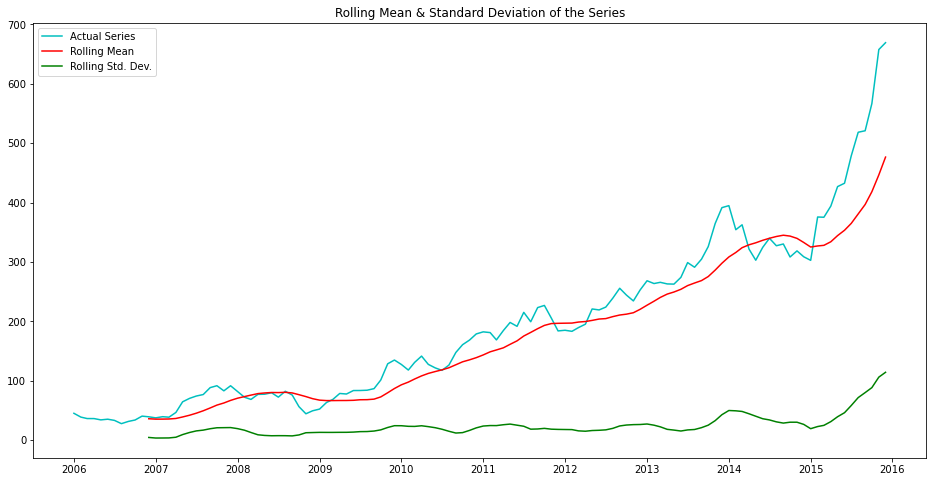

In [10]:
# Calculating the rolling mean and standard deviation for a window of 12 observations

rolmean = df_train.rolling(window = 12).mean() 

rolstd = df_train.rolling(window = 12).std()

# Visualizing the rolling mean and standard deviation

plt.figure(figsize = (16, 8))

actual = plt.plot(df_train, color = 'c', label = 'Actual Series')

rollingmean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean') 

rollingstd = plt.plot(rolstd, color = 'green', label = 'Rolling Std. Dev.')

plt.title('Rolling Mean & Standard Deviation of the Series')

plt.legend()

plt.show()

**Observations:**
- We can see there is an upward trend in the series.
- We can confirm that **the time series is not stationary.**

We can also use the **Augmented Dickey-Fuller (ADF) Test** to verify if the series is stationary or not.
The null and alternate hypotheses for the ADF Test are defined as: 
- **Null hypothesis:** The Time Series is non-stationary
- **Alternative hypothesis:** The Time Series is stationary

In [11]:
# Define a function to use ADF test

def adfuller(df_train):
    
  # Importing ADF using statsmodels
    from statsmodels.tsa.stattools import adfuller

    print('Dickey-Fuller Test:')

    adftest = adfuller(df_train['close'])

    adfoutput = pd.Series(adftest[0:4], index = ['Test Statistic', 'p-value', 'Lags Used', 'No. of Observations'])

    for key,value in adftest[4].items():

        adfoutput['Critical Value (%s)'%key] = value

    print(adfoutput)

adfuller(df_train)

Dickey-Fuller Test:
Test Statistic            3.464016
p-value                   1.000000
Lags Used                 0.000000
No. of Observations     119.000000
Critical Value (1%)      -3.486535
Critical Value (5%)      -2.886151
Critical Value (10%)     -2.579896
dtype: float64


**Observations:**
1. From the above test, we can see that the **p-value = 1, i.e., > 0.05** (for 95% confidence intervals) therefore, **we fail to reject the null hypothesis.**
2. Hence, **we can confirm that the series is non-stationary.**

## **Making the series stationary**

We can use some of the following methods to convert a non-stationary series into a stationary one:
1. **Log Transformation**
2. **By differencing the series (lagged series)**

Let's first use a log transformation over this series to remove exponential variance and check the stationarity of the series again.

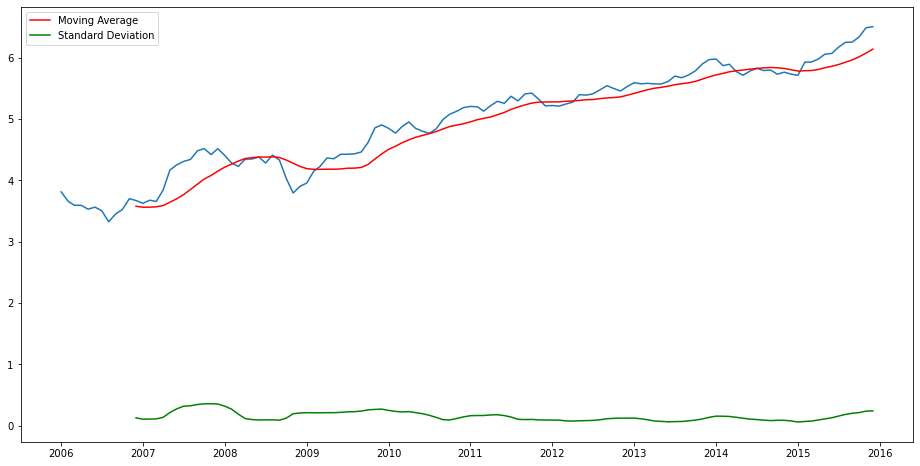

In [12]:
# Visualize the rolling mean and standard deviation after using log transformation

plt.figure(figsize = (16, 8))

df_log = np.log(df_train)

MAvg = df_log.rolling(window = 12).mean()

MStd = df_log.rolling(window = 12).std()

plt.plot(df_log)

plt.plot(MAvg, color = 'r', label = 'Moving Average')

plt.plot(MStd, color = 'g', label = 'Standard Deviation')

plt.legend()

plt.show()

**Observations:**
- Since **we can still see the upward trend in the series**, we can conclude that **the series is still non-stationary.** 
- However, the standard deviation is almost constant which implies that **now the series has a constant variance.**

**Let's shift the series by order 1 (or by 1 month) & apply differencing (using lagged series)** and then check the rolling mean and standard deviation.

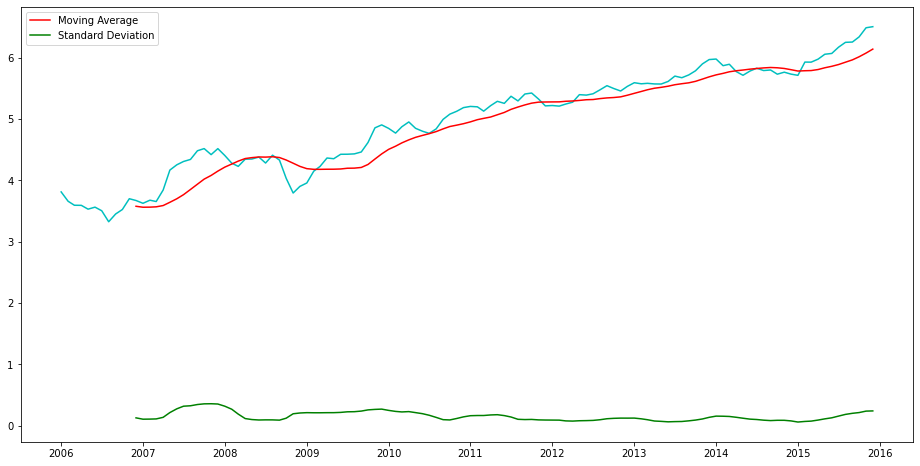

In [13]:
plt.figure(figsize = (16, 8))

df_shift = df_log - df_log.shift(periods = 1)

MAvg_shift = df_log.rolling(window=12).mean()  # Use window = 12 

MStd_shift = df_log.rolling(window=12).std()   # Use window = 12

plt.plot(df_log , color = 'c')

plt.plot(MAvg_shift , color = 'red', label = 'Moving Average')

plt.plot(MStd_shift , color = 'green', label = 'Standard Deviation')

plt.legend()

plt.show()

# Dropping the null values that we get after applying differencing method

df_shift = df_shift.dropna()

Observation:
- We can see an upward trend in the time series still.
- This is a sign that the time series might not be stationary yet.
- The standard deviation is now nearly constant which is a good sign that the differencing method worked somewhat and implies that the time series now has a constat variance.

Let us use the adfuller test to check the stationarity.

In [14]:
adfuller(df_shift)

Dickey-Fuller Test:
Test Statistic         -8.640344e+00
p-value                 5.447548e-14
Lags Used               0.000000e+00
No. of Observations     1.180000e+02
Critical Value (1%)    -3.487022e+00
Critical Value (5%)    -2.886363e+00
Critical Value (10%)   -2.580009e+00
dtype: float64


**Observation:**
- We can see that **the p-value is now far lesser than 0.05** (for 95% confidence interval), **therefore we can reject the null hypothesis that the series is non-stationary.**

We can conclude that **the series is now stationary.** Let's decompose the time series to check its different components.

## **Decomposing the time series components into Trend, Seasonality, and Residual**

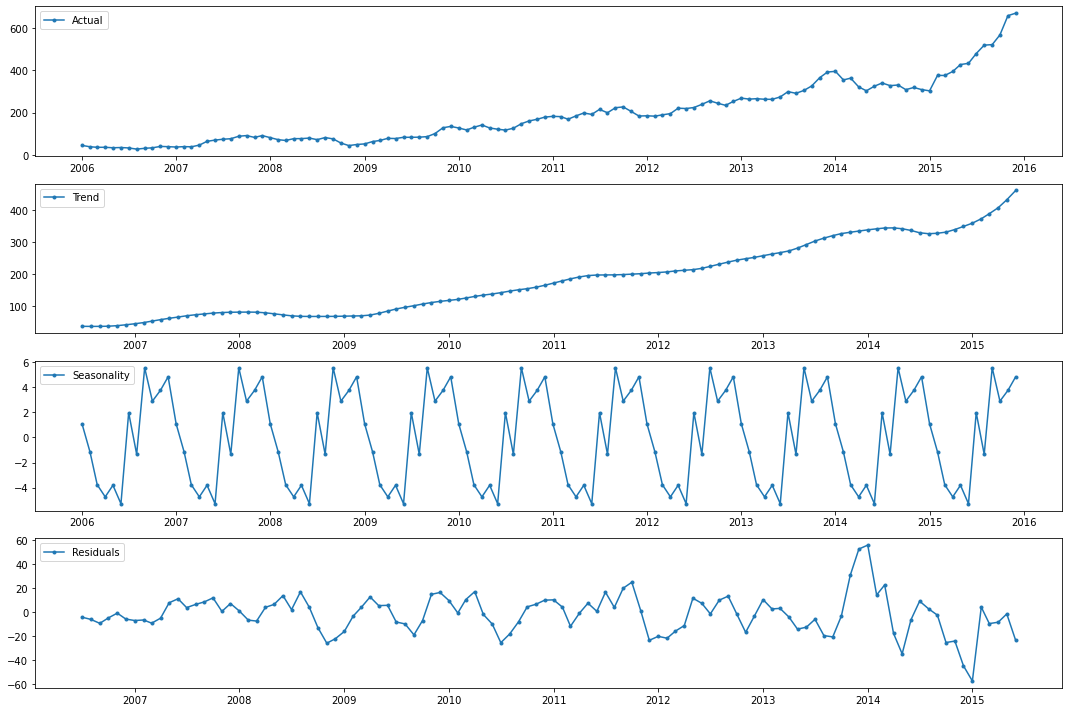

In [15]:
# Importing the seasonal_decompose function to decompose the time series

from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(df_train)

# Extracting the trend component
trend = decomp.trend

# Extracting the seasonal component
seasonal = decomp.seasonal

# Extracting the residuals
residual = decomp.resid

plt.figure(figsize = (15, 10))

plt.subplot(411)
plt.plot(df_train, label = 'Actual', marker = '.')
plt.legend(loc = 'upper left')

plt.subplot(412)
plt.plot(trend, label = 'Trend', marker = '.')
plt.legend(loc = 'upper left')

plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality', marker = '.')
plt.legend(loc = 'upper left')

plt.subplot(414)
plt.plot(residual, label = 'Residuals', marker = '.')
plt.legend(loc = 'upper left')

plt.tight_layout()

**Observations:**
- We can see that there are significant **trend, seasonality, and residuals components** in the series.
- The plot for seasonality shows that **Amazon's stock prices spike in July, September, and December.**

**Now, let's move on to the model building section. First, we will plot the `ACF` and `PACF` plots to get the values of p and q, i.e., order of AR and MA models to be used.**

## **ACF and PACF plots**

**Plotting the auto-correlation function and partial auto-correlation function to get p and q values for AR, MA, ARMA, and ARIMA models.**

<Figure size 1152x576 with 0 Axes>

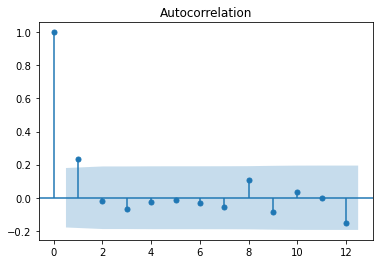

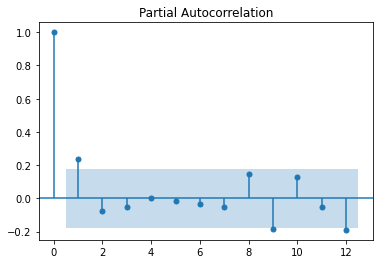

In [16]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plt.figure(figsize = (16, 8))

plot_acf(df_shift, lags = 12) 

plt.show() 

plot_pacf(df_shift, lags = 12) 

plt.show()

**Observations:**
- From the above PACF plot, we can see that **the highest lag** at which the plot extends beyond the statistically significant boundary is **lag 1.** 
- This indicates that an **AR Model of lag 1 (p = 1)** should be sufficient to fit the data.
- Similarly, from the ACF plot, we can infer that **q = 1.**

## **AR Model**

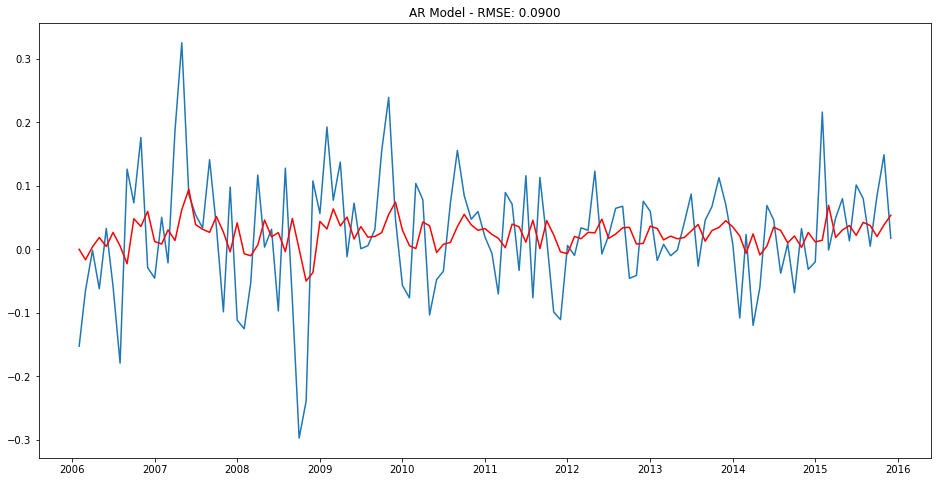

In [17]:
# Importing AutoReg function to apply AR model

from statsmodels.tsa.ar_model import AutoReg

plt.figure(figsize = (16, 8))

model_AR = AutoReg(df_shift, lags = 1) # Use number of lags as 1 and apply AutoReg function on df_shift series

results_AR = model_AR.fit() # Fit the model

plt.plot(df_shift)

predict = results_AR.predict(start = 0, end = len(df_shift) - 1) # Predict the series 

predict = predict.fillna(0) # Converting NaN values to 0

plt.plot(predict , color = 'red')

plt.title('AR Model - RMSE: %.4f'% mean_squared_error(predict, df_shift['close'], squared = False))  # Calculating rmse

plt.show()

Observations:
- Using the AR model, we get a Root Mean Squared Error of 0.0900.

**Let's check the AIC value** of the model

In [18]:
results_AR.aic

-4.781419615400342

Now, let's build MA, ARMA, and ARIMA models as well, and see if we can get a better model.

## **MA Model**

**We will be using an ARIMA model with p = 0 and d = 0 so that it will work as an MA model.**

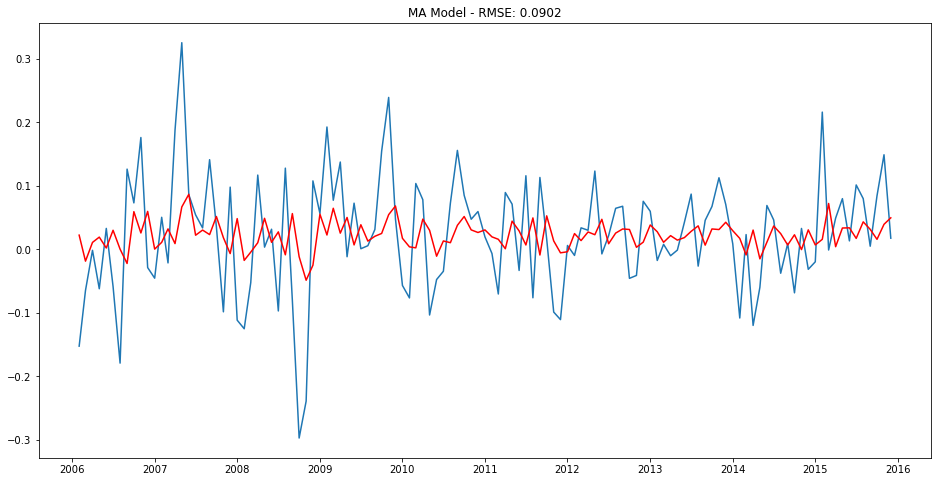

In [19]:
from statsmodels.tsa.arima_model import ARIMA

plt.figure(figsize = (16, 8))

model_MA = ARIMA(df_shift, order =(0,0,1)) # Using p = 0, d = 0, q = 1 and apply ARIMA function on df_shift series

results_MA = model_MA.fit(disp=0) # Fit the model

plt.plot(df_shift)

plt.plot(results_MA.fittedvalues, color = 'red')

plt.title('MA Model - RMSE: %.4f'% mean_squared_error(results_MA.fittedvalues, df_shift['close'], squared = False))

plt.show()

Observations:
- Python gave a message from fitting the model saying that the problem is unconstrained.
- The RMSE from this model is 0.0902.
- This is very similiar to the RMSE of 0.0900 from the AR model but slightly higher in RMSE.

**Let's check the AIC value** of the model

In [20]:
results_MA.aic

-229.09493930954125

- **The MA model is giving a much lower AIC** in comparison to the AR model, implying that **the MA model fits the training data better.** 

## **ARMA Model**

We will be using an **ARIMA model with p = 1 and q = 1** (as observed from the ACF and PACF plots) **and d = 0 so that it will work as an ARMA model.**

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.87012D-01    |proj g|=  1.55890D-01

At iterate    5    f= -9.87252D-01    |proj g|=  5.57644D-03

At iterate   10    f= -9.87385D-01    |proj g|=  1.15442D-01

At iterate   15    f= -9.87863D-01    |proj g|=  1.36668D-04

At iterate   20    f= -9.87863D-01    |proj g|=  8.10463D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     27      1     0     0   8.105D-07  -9.879D-01
  F = -0.98786257298150326     

CONVERG

 This problem is unconstrained.


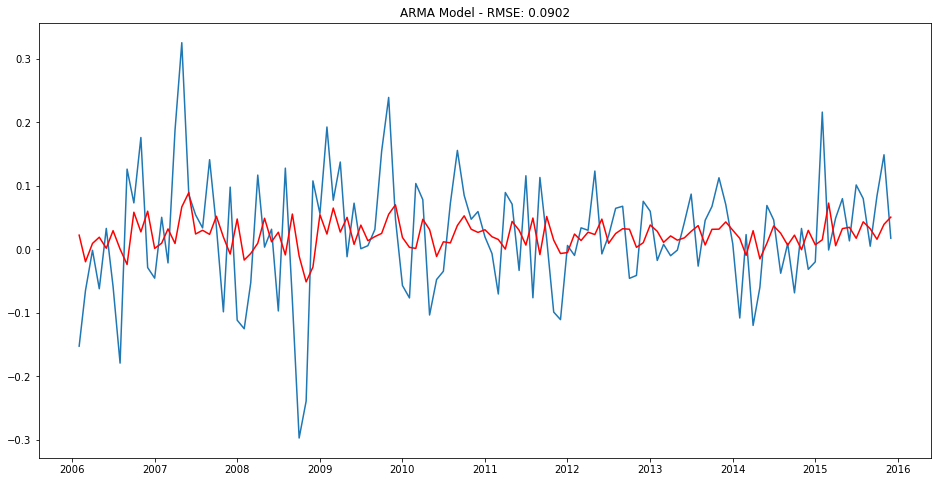

In [21]:
plt.figure(figsize = (16, 8))

model_ARMA = ARIMA(df_shift, order=(1,0,1)) # Using p = 1, d = 0, q = 1 and apply ARIMA function on df_shift series

results_ARMA = model_ARMA.fit() # Fit the model

plt.plot(df_shift)

plt.plot(results_ARMA.fittedvalues, color = 'red')

plt.title('ARMA Model - RMSE: %.4f'% mean_squared_error(results_ARMA.fittedvalues, df_shift['close'], squared = False))

plt.show()

Observations:
- I got the same message as on the previous model. I left this message in the output intentionally.
- The RMSE is identical to the MA model at 0.0902.
- The output looks very very similar to the MA model.

**Let's check the AIC value** of the model

In [22]:
results_ARMA.aic

-227.11129236959778

- **The AIC value of the ARMA model is more or less similar** to the MA model.

**Let us try using the ARIMA Model.**

## **ARIMA Model**

Here, we will be using an **ARIMA Model with p = 1, d = 1, & q = 1**.

Since we are using d=1 in the ARIMA model, it will result in double differencing of the df_log series. So, we need double shifted series in order to calculate the RMSE of the model.

In [23]:
# Getting double differenced series

df_shift2 = df_log - df_log.shift(periods = 2)

df_shift2.dropna(inplace=True)

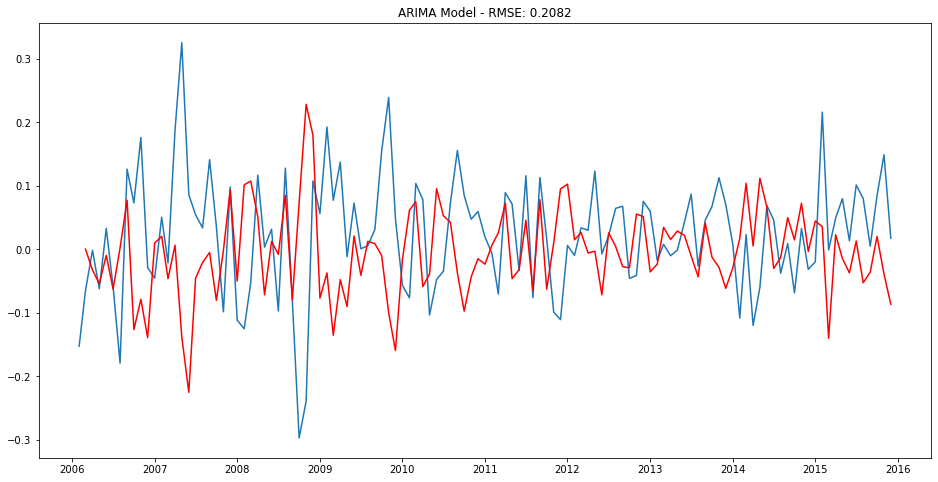

In [24]:
from statsmodels.tsa.arima_model import ARIMA

plt.figure(figsize = (16, 8))

model_ARIMA = ARIMA(df_shift, order=(1,1,1)) # Using p = 1, d = 1, q = 1 and apply ARIMA function on df_shift series

results_ARIMA = model_ARIMA.fit(disp=0) # Fit the model

plt.plot(df_shift)

plt.plot(results_ARIMA.fittedvalues, color = 'red')

plt.title('ARIMA Model - RMSE: %.4f'% mean_squared_error(results_ARIMA.fittedvalues, df_shift2['close'], squared = False))

plt.show()

Observations:
- I got another similar message from python as above. I hid it using disp=0 with the fit function.
- The RMSE here is 0.2082 which is much higher than our other models. It is over double any of the other models.
- This may not be a good model choice due to this increased error.

**Let's check the AIC value** of the model

In [25]:
results_ARIMA.aic

-219.79217243136242

- **The AIC value of the ARIMA model is higher than the ARMA model**. 

We observed that **MA and ARMA models return almost the same RMSE.** Also, there is not much difference in the AIC value of both the models.

**We can choose to predict the values using the ARMA model as it takes into account more factors than the MA model.**

In [26]:
# Printing the fitted values
predictions = pd.Series(results_ARMA.fittedvalues)

predictions

date
2006-02-01    0.022235
2006-03-01   -0.019667
2006-04-01    0.009184
2006-05-01    0.018985
2006-06-01    0.001615
                ...   
2015-08-01    0.043234
2015-09-01    0.032286
2015-10-01    0.015696
2015-11-01    0.039276
2015-12-01    0.050567
Length: 119, dtype: float64

## **Inverse Transformation**

Now we have fitted values using the ARMA model, **we will use the inverse transformation to get back the original values.**

In [27]:
# First step - doing a cumulative sum

predictions_cumsum = predictions.cumsum() # Use .cumsum fuction on the predictions

predictions_cumsum

date
2006-02-01    0.022235
2006-03-01    0.002568
2006-04-01    0.011753
2006-05-01    0.030738
2006-06-01    0.032353
                ...   
2015-08-01    2.526099
2015-09-01    2.558386
2015-10-01    2.574081
2015-11-01    2.613358
2015-12-01    2.663925
Length: 119, dtype: float64

In [28]:
# Second step - adding the first value of the log series to the cumulative sum values

predictions_log = pd.Series(df_log['close'].iloc[0], index = df_log.index)

predictions_log = predictions_log.add(predictions_cumsum, fill_value = 0)

predictions_log

date
2006-01-01    3.811539
2006-02-01    3.833774
2006-03-01    3.814108
2006-04-01    3.823292
2006-05-01    3.842277
                ...   
2015-08-01    6.337639
2015-09-01    6.369925
2015-10-01    6.385621
2015-11-01    6.424897
2015-12-01    6.475465
Length: 120, dtype: float64

In [29]:
# Third step - applying exponential transformation

predictions_ARMA = np.exp(predictions_log) # Use exponential function on predictions_log

predictions_ARMA

date
2006-01-01     45.220000
2006-02-01     46.236725
2006-03-01     45.336292
2006-04-01     45.754599
2006-05-01     46.631544
                 ...    
2015-08-01    565.459536
2015-09-01    584.014064
2015-10-01    593.252966
2015-11-01    617.017494
2015-12-01    649.020705
Length: 120, dtype: float64

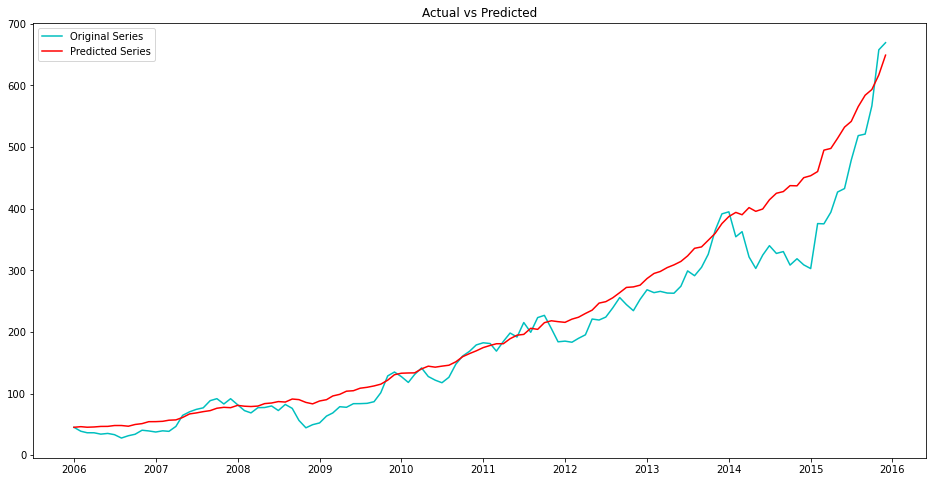

In [30]:
# Plotting the original vs predicted series

plt.figure(figsize = (16, 8))

plt.plot(df_train, color = 'c', label = 'Original Series')

plt.plot(predictions_ARMA, color = 'r', label = 'Predicted Series')

plt.title('Actual vs Predicted')

plt.legend()

plt.show()

**Observations:**
- We can see that **the predicted series is very similar to the original series**, i.e., The model is good at predicting values on the training data except for the dip in stock prices in 2015 which may have been due to some external factors that are not included in this model. 
- Let us **forecast the closing prices for the next 24 months.**

## **Forecasting the values for next 24 months and compare it with test data**

**To forecast the values for the next 24 months using the ARMA model, we need to follow the steps below:**
1. Forecast the log-transformed fitted values for the next 24 months
2. Make a list of these 24 month (2016-2017) forecasted values
3. Convert that list into a series so that we can work with pandas functions 
4. Make a dataframe where we have the dates starting from 2016-01-01 to 2017-12-01 as the index and the respective forecasted values
5. Apply the inverse transformation and get the real forecasted values

In [45]:
# Forecasting the values for next 24 months

forecasted_ARMA = results_ARMA.forecast(steps = 24)[0] # Forecast using results_ARMA for next 24 months. Keep steps = 24

forecasted_ARMA

array([0.01498676, 0.02194881, 0.02222363, 0.02223448, 0.0222349 ,
       0.02223492, 0.02223492, 0.02223492, 0.02223492, 0.02223492,
       0.02223492, 0.02223492, 0.02223492, 0.02223492, 0.02223492,
       0.02223492, 0.02223492, 0.02223492, 0.02223492, 0.02223492,
       0.02223492, 0.02223492, 0.02223492, 0.02223492])

In [46]:
# First step - doing cumulative sum

forecasted_ARMA_cumsum = forecasted_ARMA.cumsum()

forecasted_ARMA_cumsum

array([0.01498676, 0.03693557, 0.0591592 , 0.08139367, 0.10362858,
       0.1258635 , 0.14809842, 0.17033334, 0.19256826, 0.21480318,
       0.2370381 , 0.25927302, 0.28150795, 0.30374287, 0.32597779,
       0.34821271, 0.37044763, 0.39268255, 0.41491747, 0.43715239,
       0.45938732, 0.48162224, 0.50385716, 0.52609208])

In [47]:
# Second step - adding the last value of the log series to the cumulative sum values

index = pd.date_range('2016-01-1','2018-1-1', freq = '1M') - pd.offsets.MonthBegin(1)

forecasted_log = pd.Series(df_log['close'].iloc[-1], index = index)

forecasted_log = forecasted_log.add(forecasted_ARMA_cumsum, fill_value = 0)

forecasted_log

2016-01-01    6.521159
2016-02-01    6.543108
2016-03-01    6.565332
2016-04-01    6.587566
2016-05-01    6.609801
2016-06-01    6.632036
2016-07-01    6.654271
2016-08-01    6.676506
2016-09-01    6.698741
2016-10-01    6.720976
2016-11-01    6.743211
2016-12-01    6.765446
2017-01-01    6.787681
2017-02-01    6.809915
2017-03-01    6.832150
2017-04-01    6.854385
2017-05-01    6.876620
2017-06-01    6.898855
2017-07-01    6.921090
2017-08-01    6.943325
2017-09-01    6.965560
2017-10-01    6.987795
2017-11-01    7.010030
2017-12-01    7.032265
dtype: float64

In [48]:
# Applying exponential transformation to the forecasted log values

forecasted_ARMA = np.exp(forecasted_log) # Use exponential function on forecasted_log

forecasted_ARMA

2016-01-01     679.365576
2016-02-01     694.441687
2016-03-01     710.047466
2016-04-01     726.011821
2016-05-01     742.335428
2016-06-01     759.026067
2016-07-01     776.091979
2016-08-01     793.541599
2016-09-01     811.383556
2016-10-01     829.626671
2016-11-01     848.279964
2016-12-01     867.352656
2017-01-01     886.854178
2017-02-01     906.794171
2017-03-01     927.182495
2017-04-01     948.029228
2017-05-01     969.344679
2017-06-01     991.139386
2017-07-01    1013.424123
2017-08-01    1036.209910
2017-09-01    1059.508012
2017-10-01    1083.329947
2017-11-01    1107.687494
2017-12-01    1132.592694
dtype: float64

Now, let's try to visualize the original data with the predicted values on the training data and the forecasted values.

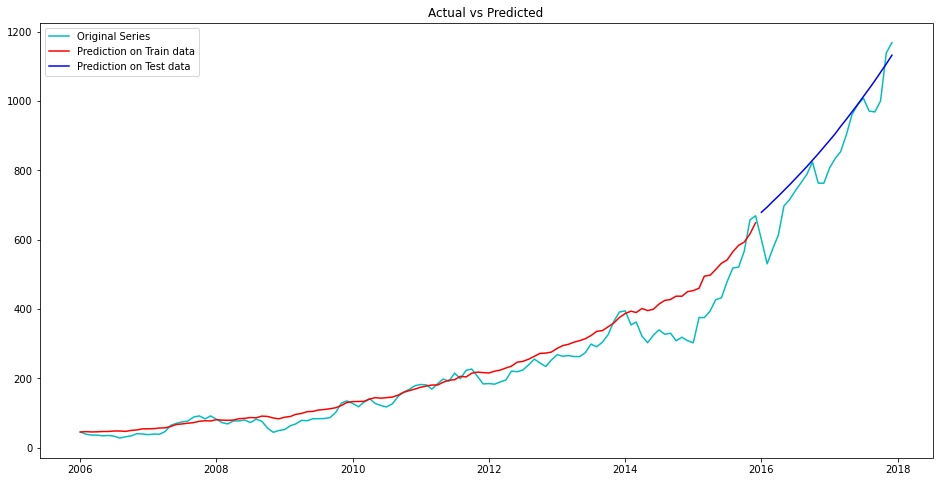

In [49]:
# Plotting the original vs predicted series

plt.figure(figsize = (16, 8))

plt.plot(df, color = 'c', label = 'Original Series')

plt.plot(predictions_ARMA, color = 'r', label = 'Prediction on Train data') # Plot the predictions_ARMA series

plt.plot(forecasted_ARMA, label = 'Prediction on Test data', color = 'b')  # Plot the forecasted_ARMA series

plt.title('Actual vs Predicted')

plt.legend()

plt.show()

- **As observed earlier, most of the predicted values on the training data are very close to the actual values** except for the dip in stock prices in 2015.
- **On the test data, the model can correctly predict the trend of the stock prices**, as we can see that the blue line appears to be close to the actual values (cyan blue), and they both have an upward trend. **However, the test predictions are not able to identify the volatile variations in the stock prices over the last two years.**


Let's test the RMSE of the transformed predictions and the original value on the training and testing data to check whether the model is giving a generalized performance or not.

In [50]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(predictions_ARMA,df_train) # Calculate RMSE using the predictions_ARMA and df_train

error

1872.5163693750035

In [52]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(forecasted_ARMA,df_test)  # Calculate RMSE using the forecasted_ARMA and df_test

error

5386.622111150652

Conclusion:
- Our task was to build and analyze different time series models using AR,MA,ARMA, and ARIMA models to forecast the stock closing price of Amazon.
- The models were created with data from 2006-2016.
- After evaluation RMSE and AIC values from the 4 models, we decided to go with the ARMA (auto-regressive moving average) model.
- This model was performing similarly to the MA (moving average) model, but the ARMA model uses both past values as well as past error instead of just past values like the MA model does so we went with the ARMA model to forecast future stock prices.
- The ARMA model had an AIC of -227 and an RMSE of 0.0902.
- Using this model, we forecasted stock prices over the last 2 years.
- Comparing the model forecast to the actual stock price, the model did a very good job keeping up with the increase of stock value. The model unfortunately is unable to account for volatile variations in the stock price. An example of this is seen in 2015 when there was a strange decrease in stock prices.
